<a href="https://colab.research.google.com/github/quanndm/kltn/blob/dev/notebooks/visualize.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Init - import library - download data

In [1]:
!rm -rf kltn
!rm -rf sample_data
!git clone -b dev https://github.com/quanndm/kltn.git

Cloning into 'kltn'...
remote: Enumerating objects: 3133, done.
remote: Counting objects: 100% (16/16), done.
remote: Compressing objects: 100% (15/15), done.
remote: Total 3133 (delta 8), reused 1 (delta 1), pack-reused 3117 (from 3)
Receiving objects: 100% (3133/3133), 86.04 MiB | 11.24 MiB/s, done.
Resolving deltas: 100% (2146/2146), done.


In [2]:
from kltn.init.install_dependencies import install_packages, load_config
install_packages("./kltn")
config = load_config("./kltn/parameters.yaml")

In [3]:
import torch
import matplotlib.pyplot as plt
import numpy as np
from google.colab import drive
import json
import pathlib
import re

from kltn import *
from kltn.datasets.lits import Lits, Stage2Dataset2D
from kltn.datasets.get_datasets import get_datasets_lits, convert_to_2D_dataset_v1
from kltn.utils.logger import init_logger
from kltn.utils.train_val_epochs import  trainer_stage1
from kltn.utils.metrics import  DiceMetric, TverskyLossWSigmoid, DiceLossWSigmoid
from kltn.models.model_factory import ModelFactory
from kltn.utils.visualize_results import visualize_results, visualize_results_stage_1
from kltn.processing.preprocessing import resize_crop_to_bbox_size, uncrop_to_full_image, resize_image
from kltn.processing.postprocessing import post_trans_stage1, post_processing_stage2
from skimage.transform import resize

In [ ]:
drive.flush_and_unmount()
drive.mount("/content/gdrive")

Drive not mounted, so nothing to flush and unmount.
Mounted at /content/gdrive


In [ ]:
from kltn.datasets.prepare_data import prepare_dataset_LiTS
prepare_dataset_LiTS(dir_name=config["source_folder_lits"])

0.00% complete (down: 0.0 kB/s up: 0.0 kB/s peers: 1) downloading LITS17 (https://academictorrents.com/announce.php)[127.0.0.1:6881] v1 skipping tracker announce (unreachable) "" (1)
LITS17 (https://ipv6.academictorrents.com/announce.php)[127.0.0.1:6881] v1 skipping tracker announce (unreachable) "" (1)
LITS17 (https://academictorrents.com/announce.php)[172.28.0.12:6881] v1 unspecified system error "" (1)
LITS17 (https://ipv6.academictorrents.com/announce.php)[172.28.0.12:6881] v1 unspecified system error "" (1)
0.00% complete (down: 0.2 kB/s up: 0.1 kB/s peers: 3) downloading LITS17 (udp://tracker.opentrackr.org:1337/announce)[127.0.0.1:6881] v1 skipping tracker announce (unreachable) "" (1)
1.17% complete (down: 19794.7 kB/s up: 586.4 kB/s peers: 9) downloading LITS17 (https://academictorrents.com/announce.php)[127.0.0.1:6881] v1 skipping tracker announce (unreachable) "" (2)
LITS17 (https://ipv6.academictorrents.com/announce.php)[127.0.0.1:6881] v1 skipping tracker announce (unreach

In [8]:
model1 = ModelFactory.get_model("unet3d_resnextcot_mcb",in_channels=1, n_classes=1, n_channels=16)
total_params1 = sum(p.numel() for p in model1.parameters())
total_params1

2009313

In [9]:
model2= ModelFactory.get_model("unet2d_resnextcot_mcb",in_channels=3, n_classes=1, n_channels=32)
total_params2 = sum(p.numel() for p in model2.parameters())
total_params2

2474945

## utils function

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
from matplotlib.colors import ListedColormap
import matplotlib

def visualize_ct_slice(ct_array=None, mask_array=None, axis=0, slice_index=None,
                       alpha=0.4, cmap='gray', mask_cmap='tab10', tumor=False, ax=None):
    """
    Hiển thị 1 slice từ ảnh CT 3D (và overlay mask nếu có). Hỗ trợ subplot thông qua `ax`.

    Parameters:
    - ct_array: ndarray từ sitk.GetArrayFromImage (shape: [Z, Y, X])
    - mask_array: mask nhị phân cùng shape, có thể None
    - axis: trục cắt (0: axial, 1: coronal, 2: sagittal)
    - slice_index: chỉ số slice, nếu None sẽ lấy slice giữa
    - alpha: độ trong suốt của mask overlay
    - ax: matplotlib axis để vẽ vào subplot
    """
    import numpy as np
    import matplotlib.pyplot as plt
    from matplotlib.colors import ListedColormap

    if ct_array is None and mask_array is None:
        raise ValueError("Cần ít nhất một trong hai: ct_array hoặc mask_array")

    ref_array = ct_array if ct_array is not None else mask_array

    if slice_index is None:
        slice_index = ref_array.shape[axis] // 2

    # Cắt slice
    if axis == 0:
        ct_slice = ct_array[slice_index, :, :] if ct_array is not None else None
        mask_slice = mask_array[slice_index, :, :] if mask_array is not None else None
    elif axis == 1:
        ct_slice = ct_array[:, slice_index, :] if ct_array is not None else None
        mask_slice = mask_array[:, slice_index, :] if mask_array is not None else None
    elif axis == 2:
        ct_slice = ct_array[:, :, slice_index] if ct_array is not None else None
        mask_slice = mask_array[:, :, slice_index] if mask_array is not None else None
    else:
        raise ValueError("Axis phải là 0, 1 hoặc 2.")

    # Nếu không có CT thì tạo nền đen
    if ct_slice is None:
        ct_slice = np.zeros_like(mask_slice, dtype=np.uint8)

    # Chọn trục vẽ
    if ax is None:
        fig, ax = plt.subplots(figsize=(6, 6))

    ax.imshow(ct_slice, cmap=cmap)

    # Overlay mask nếu có
    if mask_slice is not None:
        if np.array_equal(np.unique(mask_slice), [0, 1, 2]):
            custom_colors = [
                [0, 0, 0, 0.0],            # label 0
                [0, 1.0, 127/255, 0.5],    # label 1
                [1.0, 0, 0, 1.0],          # label 2
            ]
        else:
            if tumor:
                custom_colors = [
                    [0, 0, 0, 0.0],        # label 0
                    [1.0, 0, 0, 1.0],      # label 2
                ]
            else:
                custom_colors = [
                    [0, 0, 0, 0.0],        # label 0
                    [0, 1.0, 127/255, 0.5],# label 1
                ]
        custom_cmap = ListedColormap(custom_colors)
        ax.imshow(mask_slice, cmap=custom_cmap, alpha=alpha, interpolation='none')
    # Tắt toàn bộ khoảng trắng ngoài lề
    plt.subplots_adjust(left=0, right=1, top=1, bottom=0, wspace=0, hspace=0)

    # ax.set_title(f"Slice {slice_index} (axis={axis})")
    ax.axis('off')

    if ax is None:
        plt.show()


In [ ]:
def find_best_slice(ct_array, mask_array=None, axis=0, threshold=0.01):
    """
    Tìm slice có nội dung nhiều nhất (ít background nhất) theo 1 trục.
    Nếu có mask: chọn slice có nhiều pixel mask nhất.

    Parameters:
    - ct_array: ndarray từ sitk.GetArrayFromImage
    - mask_array: ndarray mask hoặc None
    - axis: trục (0, 1, 2)
    - threshold: nếu không có mask, số pixel > ngưỡng coi là foreground

    Returns:
    - index của slice tốt nhất
    """
    if mask_array is not None:
        num_slices = mask_array.shape[axis]
        scores = []
        for i in range(num_slices):
            if axis == 0:
                mask = mask_array[i, :, :]
            elif axis == 1:
                mask = mask_array[:, i, :]
            elif axis == 2:
                mask = mask_array[:, :, i]
            scores.append(np.sum(mask))
    else:
        # Dùng CT để đánh giá slice "có thông tin"
        num_slices = ct_array.shape[axis]
        scores = []
        for i in range(num_slices):
            if axis == 0:
                sl = ct_array[i, :, :]
            elif axis == 1:
                sl = ct_array[:, i, :]
            elif axis == 2:
                sl = ct_array[:, :, i]
            scores.append(np.mean(np.abs(sl)) > threshold)

    best_index = int(np.argmax(scores))
    return best_index

In [ ]:
def preprocessing_liver(image_ct, mask_liver):
  image, seg = Lits.preprocessing(image_ct, mask_liver, False, normalizations="zscores")
  seg = (seg > 0).astype(np.uint8)

  image, seg = image.astype(np.float32), seg.astype(np.uint8)
  image, seg = torch.from_numpy(image), torch.from_numpy(seg)

  return image, seg

In [ ]:
def preprocessing_tumor(compressed_array_path):
  data = Stage2Dataset2D.load_npz(compressed_array_path)
  _image, _seg, bbox = data["image"], data["seg"], data["bbox"]
  image, seg = Stage2Dataset2D.preprocessing(_image, _seg, False, normalizations="zscores")

  liver_mask = (seg > 0).astype(np.uint8)
  image, seg = image.astype(np.float32), (seg == 2).astype(np.uint8)
  image, seg = torch.from_numpy(image), torch.from_numpy(seg)

  return image, seg, liver_mask, bbox

In [ ]:
def paste_mask_to_full(mask_pred, bbox, full_shape):
    """
    Đưa mask nhỏ vào lại vị trí cũ trong CT slice full size.

    Parameters:
    - mask_pred: mask 2D đã predict, shape (h, w)
    - bbox: [z, y1, x1, y2, x2] — vị trí crop ban đầu
    - full_shape: (H, W) — kích thước lát CT gốc

    Returns:
    - full_mask: mask full size với vùng predict được dán vào đúng vị trí
    """
    y_min, y_max, x_min, x_max = bbox
    full_mask = np.zeros(full_shape, dtype=mask_pred.dtype)

    h, w = y_max - y_min, x_max - x_min

    # Resize mask nếu cần thiết
    if mask_pred.shape != (h, w):
        mask_pred = resize(
            mask_pred,
            (h, w),
            order=0,  # nearest-neighbor để giữ nhãn
            preserve_range=True,
            anti_aliasing=False
        ).astype(mask_pred.dtype)

    full_mask[y_min:y_max, x_min:x_max] = mask_pred

    return np.expand_dims(full_mask, axis=0)

In [ ]:
path = "/content/LITS17/"
index = 22
# index = 4

## Visualize Liver

In [ ]:
image = Lits.load_nii(f"{path}/volume-{index}.nii")
mask = Lits.load_nii(f"{path}/segmentation-{index}.nii")

best slide:  132


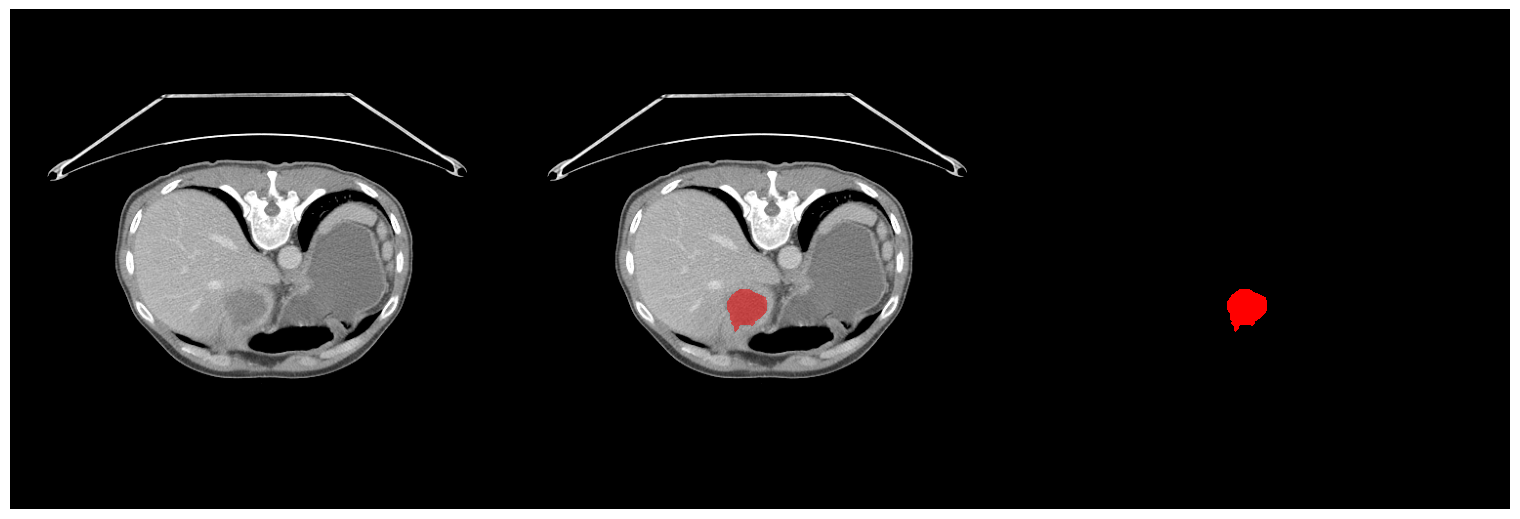

In [ ]:
mask_ = (mask==2).astype(np.uint8)
best_slide = find_best_slice(image, mask_)
image = np.clip(image, -200, 250)
print("best slide: ", best_slide)
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
fig.patch.set_visible(False)
visualize_ct_slice(image, None, slice_index=best_slide,  ax=axes[0])
visualize_ct_slice(image, mask_, slice_index=best_slide, tumor=True, alpha=0.5,  ax=axes[1])
visualize_ct_slice(None, mask_, slice_index=best_slide, tumor=True, alpha=1,  ax=axes[2])

In [ ]:
import glob
print(glob.glob("/content/gdrive/MyDrive/KLTN/code/weight/best_metric_*liver*.pth"))

['/content/gdrive/MyDrive/KLTN/code/weight/best_metric_model_UNet3DWResNeXtCoT_liver.pth', '/content/gdrive/MyDrive/KLTN/code/weight/best_metric_model_UNet3DWResNeXtCoT_liver_1.pth', '/content/gdrive/MyDrive/KLTN/code/weight/best_metric_model_MSC_CoTNeXtUNet_liver_mcb.pth', '/content/gdrive/MyDrive/KLTN/code/weight/best_metric_model_MSCoTNeXtUNet_liver_msa.pth']


In [ ]:
weight_liver = "/content/gdrive/MyDrive/KLTN/code/weight/best_metric_model_MSC_CoTNeXtUNet_liver_mcb.pth"
model_liver = ModelFactory.get_model("unet3d_resnextcot_mcb",in_channels=1, n_classes=1, n_channels=16).to(device)
model_liver.load_state_dict(torch.load(weight_liver))

<All keys matched successfully>

In [ ]:
model_liver.eval()
ct_prep, mask_prep = preprocessing_liver(image, mask)
ct_prep, mask_prep = ct_prep.unsqueeze(0).to(device), mask_prep.unsqueeze(0).to(device)
with torch.no_grad():
  logits = model_liver(ct_prep)
mask_pred = post_trans_stage1(logits.squeeze())
mask_pred = mask_pred.cpu().numpy()
ct_prep = ct_prep.squeeze().cpu().numpy()

In [ ]:
image_liver, seg_liver = resize_image(np.expand_dims(ct_prep, axis=0), np.expand_dims(mask_pred, axis=0), target_size=(image.shape[0], image.shape[1], image.shape[2]))
image_liver, seg_liver  = image_liver.squeeze(), seg_liver.squeeze()

In [ ]:
mask = (mask > 0).astype(np.uint8)

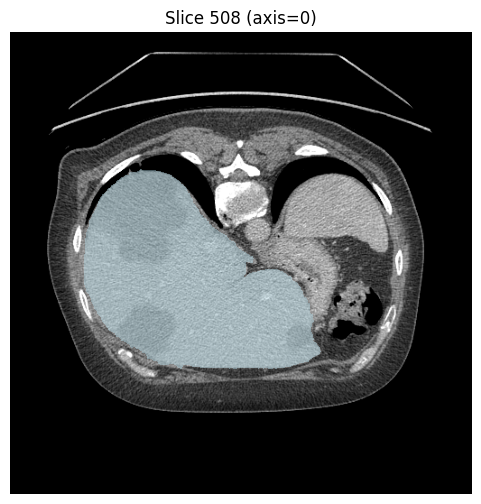

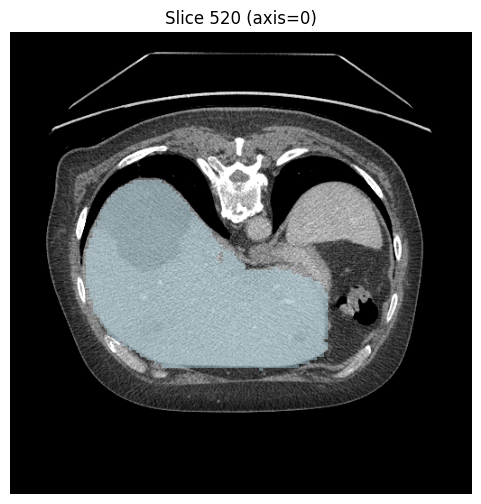

In [ ]:
best_slide_pred = find_best_slice(image_liver, seg_liver)
visualize_ct_slice(image, mask, slice_index=best_slide)
visualize_ct_slice(image, seg_liver, slice_index=best_slide_pred)

In [ ]:
model_liver.eval()
ct_prep, mask_prep = preprocessing_liver(image, mask)
ct_prep, mask_prep = ct_prep.unsqueeze(0).to(device), mask_prep.unsqueeze(0).to(device)
with torch.no_grad():
  logits = model_liver(ct_prep)
mask_pred = post_trans_stage1(logits.squeeze())
mask_pred = mask_pred.cpu().numpy()
ct_prep = ct_prep.squeeze().cpu().numpy()

image_liver, seg_liver = resize_image(np.expand_dims(ct_prep, axis=0), np.expand_dims(mask_pred, axis=0), target_size=(image.shape[0], image.shape[1], image.shape[2]))
image_liver, seg_liver  = image_liver.squeeze(), seg_liver.squeeze()
mask = (mask > 0).astype(np.uint8)

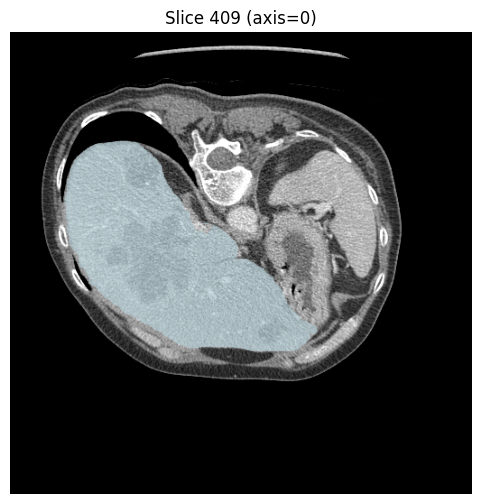

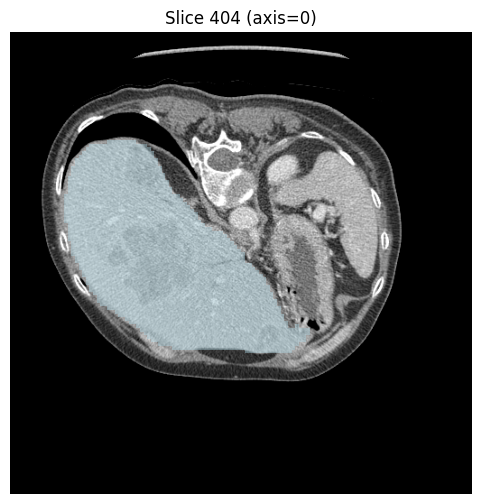

In [ ]:
best_slide_pred = find_best_slice(image_liver, seg_liver)
visualize_ct_slice(image, mask, slice_index=best_slide)
visualize_ct_slice(image, seg_liver, slice_index=best_slide_pred)

## Visualize Tumor

In [ ]:
import json

path_save_result = f"/content/gdrive/MyDrive/KLTN/bbox.json"
def load_json(json_path):
    with open(json_path, 'r') as f:
        return json.load(f)

liver_masks_bbox = load_json(path_save_result)

In [ ]:
convert_to_2D_dataset_v1(source=config["source_folder_lits"], bbox=liver_masks_bbox, slides=3, save_dir=config["path_save_dataset_2D"]) # 3 slide of 3d and stride 2

In [ ]:
base_folder = pathlib.Path(config["path_save_dataset_2D"]).resolve()


# Get the list of volume the files in the folder
patient_files = list(base_folder.glob('*patient*.npz'))
str_paths = [str(p) for p in patient_files]
pattern_1 = re.compile(rf"patient_{4}(?=_|\D)")
filtered_1 = [p for p in str_paths if pattern_1.search(p)]

pattern_2 = re.compile(rf"patient_{16}(?=_|\D)")
filtered_2 = [p for p in str_paths if pattern_2.search(p)]

In [ ]:
image_1 = Lits.load_nii(f"{path}/volume-4.nii")
image_1 = np.clip(image_1, -200, 250)
mask_1 = Lits.load_nii(f"{path}/segmentation-4.nii")

image_2 = Lits.load_nii(f"{path}/volume-16.nii")
image_2 = np.clip(image_2, -200, 250)
mask_2 = Lits.load_nii(f"{path}/segmentation-16.nii")

In [ ]:
best_slide_1 = find_best_slice(image_1, mask_1)
best_slide_2 = find_best_slice(image_2, mask_2)
print(best_slide_1, best_slide_2)

508 409


In [ ]:
patient_1_path = "/content/2D_dataset/patient_4_slice_507.npz" # 506, 507, 508
patient_2_path = "/content/2D_dataset/patient_16_slice_409.npz" # 408, 409, 410

In [ ]:
weight_tumor = "/content/gdrive/MyDrive/KLTN/code/weight/best_metric_model_MSC_CoTNeXtUNet2D_tumor_mcb.pth"
model_tumor = ModelFactory.get_model("unet2d_resnextcot_mcb",in_channels=3, n_classes=1, n_channels=32).to(device)
model_tumor.load_state_dict(torch.load(weight_tumor))

<All keys matched successfully>

In [ ]:
image_tumor_1, mask_tumor_1, liver_mask_1, bbox_1 = preprocessing_tumor(patient_1_path)
image_tumor_2, mask_tumor_2, liver_mask_2, bbox_2 = preprocessing_tumor(patient_2_path)

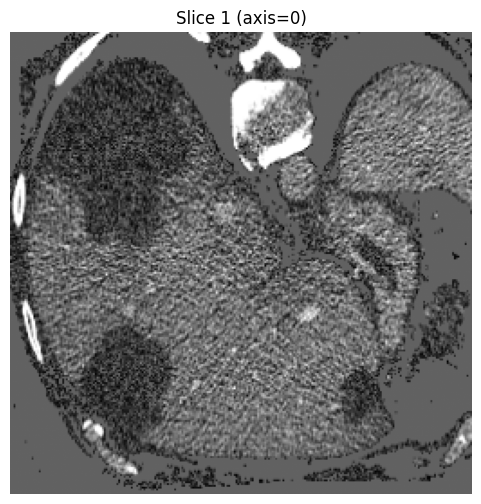

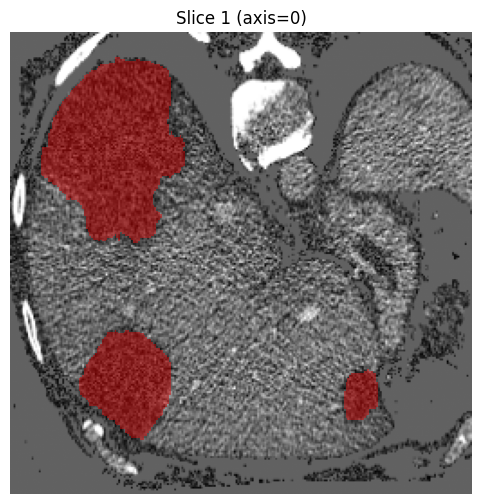

In [ ]:
visualize_ct_slice(image_tumor_1.cpu().numpy(), None, tumor=True, slice_index=1)
visualize_ct_slice(image_tumor_1.cpu().numpy(), mask_tumor_1.cpu().numpy(), tumor=True, slice_index=1)


In [ ]:
model_tumor.eval()
ct_prep_1, mask_prep_1 = image_tumor_1.unsqueeze(0).to(device), mask_tumor_1.unsqueeze(0).to(device)
ct_prep_2, mask_prep_2 = image_tumor_2.unsqueeze(0).to(device), mask_tumor_2.unsqueeze(0).to(device)
with torch.no_grad():
  logits_1 = model_tumor(ct_prep_1)
  logits_2 = model_tumor(ct_prep_2)

mask_pred_1 = post_processing_stage2(logits_1.squeeze()).cpu().numpy()
mask_pred_2 = post_processing_stage2(logits_2.squeeze()).cpu().numpy()

ct_prep_1 = ct_prep_1.squeeze().cpu().numpy()
ct_prep_2 = ct_prep_2.squeeze().cpu().numpy()

In [ ]:
bb = [item for item in liver_masks_bbox if item['patient_id'] in [16, 4]]
bb_1 = [item for item in bb if item['patient_id'] == 4][0]["bbox"][2:6]
bb_2 = [item for item in bb if item['patient_id'] == 16][0]["bbox"][2:6]


In [ ]:
bb_1

[140, 392, 68, 400]

In [ ]:
image_1_2d = image_1[best_slide_1]
image_2_2d = image_2[best_slide_2]
print(image_1_2d.shape, image_2_2d.shape)

(512, 512) (512, 512)


In [ ]:
mask_full_1 = paste_mask_to_full(mask_pred_1.squeeze(), bbox=bb_1, full_shape=image_1_2d.shape)
mask_full_2 = paste_mask_to_full(mask_pred_2.squeeze(), bbox=bb_2, full_shape=image_2_2d.shape)

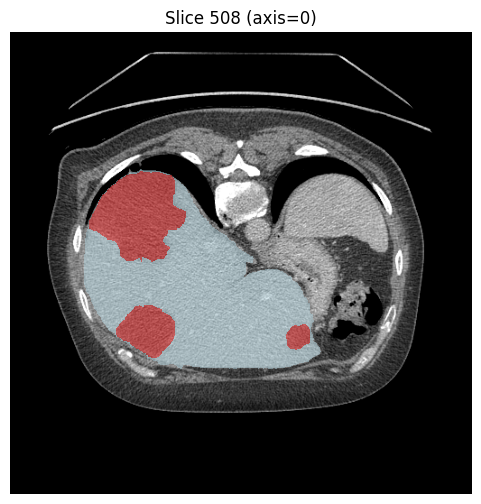

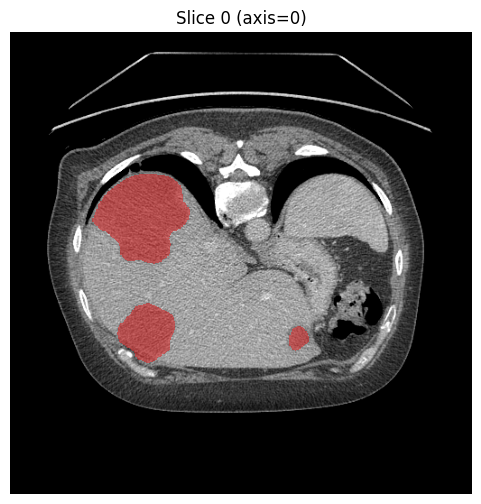

In [ ]:
visualize_ct_slice(image_1, mask_1, slice_index=best_slide_1)
visualize_ct_slice(np.expand_dims(image_1_2d, axis=0), mask_full_1, slice_index=0, tumor=True)

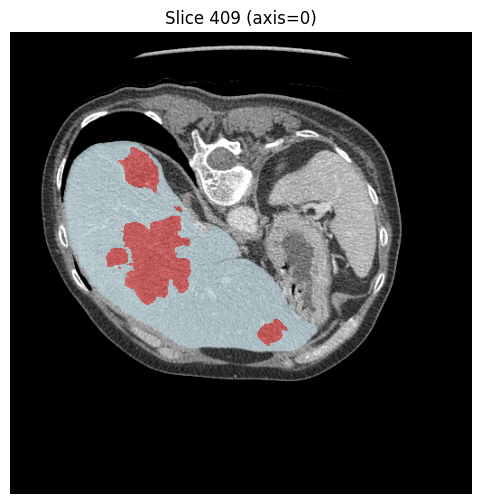

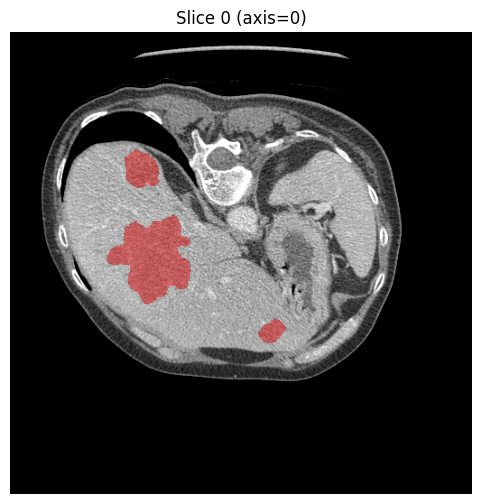

In [ ]:
visualize_ct_slice(image_2, mask_2, slice_index=best_slide_2)
visualize_ct_slice(np.expand_dims(image_2_2d, axis=0), mask_full_2, slice_index=0, tumor=True)